# <p style="text-align: center;"> Clinical Pathways Data</p>

## Описание

    На данном этапе исследование предполагается проделать следующие шаги:  
        1. Сбор признаков из файлов формата xml  
        2. Построение на их основе DataFrame  
        3. Проведение EDA для получившегося DataFrame

In [1]:
from lxml import etree as et
import pandas as pd
import numpy as np
import re
import os

import warnings
warnings.simplefilter("ignore")

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "svg"

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import pandas as pd

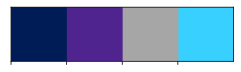

In [2]:
colors = ['#001c57','#50248f','#a6a6a6','#38d1ff']
sns.palplot(sns.color_palette(colors))

## 1. Сбор признаков из файлов формата xml

1.1 Определим необходимы признаки

In [3]:
df_columns = ["Файл", "Ф.И.О.", "Дата поступления в приемное отделение", "Время поступления в приемное отделение",
              "Пол","Вес, кг", "Рост, см", "Полных лет",
              "Основной диагноз",
              "Цель поступления", "Госпитализирован по поводу данного заболевания в текущем году",
              "Дата поступления в реанимационное отделение", "Время поступления в реанимационное отделение",
              "Пребывание в отделении реанимации (койко-день)", "Исход госпитализации",
              "Дата выписки", "Время выписки", "Место выписки", "Результат госпитализации"]

1.2 Функции, которые пригодятся для сбора признаков

In [4]:
df = []

def get_date(date):
    return (".".join(re.findall("\d+", date)))

def get_time(time):
    return (":".join(re.findall("\d+", time)))

def get_diagnosis(line):
    if "ИБС" in line: return "ИБС"
    if "ОКС" in line: return "ОКС"

def get_data(line,subline):
    srt = str.find(line,subline) + len(subline) + 1
    end = len(line)
    pos = str.find(line,":", srt)
    if pos != -1: end = pos
    return line[srt:end].strip()

def get_age(line,subline):
    srt = str.find(line,subline) + len(subline) + 1
    return "".join(re.findall("\d+",line[srt:srt+3]))

def get_status(line, subline):
    if "Выписан" in line: return "Выписан"
    srt = str.find(line,subline) + len(subline) + 1
    end = str.find(line,":",srt)
    return line[srt:end].strip()

def get_days(days):
    if days == "": return 1
    else: return days + 1

1.3 Функции для заполнения пропущенных значений

In [5]:
#Заполняет пропуск в графе пол согласно имени пациента (мужское/женское)
def fill_sex(data):
    for i, item in enumerate(data):
        if item[1] != "":
            srt = str.find(item[1]," ")
            end = str.find(item[1]," ",srt+1)-1
            if item[1][end] == "а" or item[1][end] == "я":
                data[i][4] = "Ж"
            else: data[i][4] = "М"

#Объеденит(пол,вес,рост,возраст) для всех повторений одного и того же пациента
def fill_gaps(data):
    fill_data = {}
    for row in data:
        if row[0] not in fill_data.keys():
            fill_data.update({row[0]:[row[4],row[5],row[6],row[7]]})
        else:
            for i, item in enumerate(fill_data[row[0]]):
                if item == "": fill_data[row[0]][i] = row[i+4]
    for i, item in enumerate(data):
        for j in range(4):
           data[i][j+4] = fill_data[item[0]][j]

1.4 Функция создания DataFrame

In [6]:
def make_df(df):
    for i,_ in enumerate(df):
        df[i] = pd.DataFrame([df[i]], columns = df_columns)
    df = pd.concat(df)
    df.index = df["Файл"]
    df = df.drop(["Файл"], axis=1)
    return df

1.5 Функция поиска признаков (какая же она страшненькая(, где-то я свернул не туда...)

In [7]:
def find_data(line, data, index):
    if data[index][1] == "" and ("Ф.И.О." in line):
       data[index][1] = get_data(line, "Ф.И.О.")
       return
    if data[index][2] == "" and "Дата поступления в приемное отделение" in line:
       data[index][2] = get_date(line)
       return
    if data[index][3] == "" and "Время поступления в приемное отделение" in line:
       data[index][3] = get_time(line)
       return
    if data[index][4] == "" and ("мужчина" in line.lower() or "мужской" in line.lower()):
       data[index][4] = "М"
       return
    if data[index][4] == "" and ("женщина" in line.lower() or "женский" in line.lower()):
       data[index][4] = "Ж"
       return
    if data[index][5] == "" and ("Веc, кг" in line):
       data[index][5] = get_data(line, "Веc, кг")
       return
    if data[index][6] == "" and ("Рост, см" in line):
       data[index][6] = get_data(line, "Рост, см")
       return
    if data[index][7] == "" and ("Возраст" in line):
       data[index][7] = get_age(line, "Возраст")
       return
    if data[index][8] == "" and ("ИБС" in line or "ОКС" in line):
       data[index][8] = get_diagnosis(line)
       return
    if data[index][9] == "" and ("Цель поступления" in line):
       data[index][9] = get_data(line, "Цель поступления")
       return
    if data[index][10] == "" and ("Госпитализирован по поводу данного заболевания в текущем году" in line):
       data[index][10] = get_data(line, "Госпитализирован по поводу данного заболевания в текущем году")
       return
    if data[index][11] == "" and "Дата поступления" in line and "Дата поступления в приемное отделение" not in line:
       data[index][11] = get_date(line)
       return
    if data[index][12] == "" and "Время поступления" in line and "Время поступления в приемное отделение" not in line:
       data[index][12] = get_time(line)
       return
    if "Пребывание в отделении реанимации (1 койко-день)" in line:
       data[index][13] = get_days(data[index][13])
       return
    if data[index][15] == "" and ("Дата выписки" in line):
       data[index][15] = get_date(line)
       return
    if data[index][16] == "" and ("Время выписки" in line):
       data[index][16] = get_time(line)
       return
    if data[index][14] == "" and ("Исход госпитализации" in line):
       data[index][14] = get_status(line, "Исход госпитализации")
    if data[index][17] == "" and ("Место выписки" in line):
       data[index][17] = get_data(line, "Место выписки")
       return
    if data[index][18] == "" and ("Результат госпитализации" in line):
       data[index][18] = get_data(line, "Результат госпитализации")

1.6 Функция, которая собирает из обработанных файлов будущий DF  

In [8]:
def etree2df(tree,file):
     index = -1 #номер п.п пациента в файле
     root = tree.getroot()
     data = [[""]*len(df_columns) for i in range(len(root))] #количество элемнтов в руте - количество пациентов
     tags = []
     for elem in root:
         tags.append(str(elem.tag)) #сохраняем тэги соответсвующие пациентам
     for elem in tree.iter():
         line = str(elem.text) #считываем строку и выполняем в ней поиск необходимой информации
         if str(elem.tag) in tags:
            index+= 1
            data[index][0] = file
         find_data(line, data, index)
     for i in range(index+1):
        df.append(data[i])

1.7 Сейчас такое покажу...

In [9]:
list_of_files = os.listdir("Cases_with_html")
for file in list_of_files:
    tree = et.parse(open("Cases_with_html/" + file, errors='ignore'))
    etree2df(tree,file[:-4])
fill_sex(df)
fill_gaps(df)
df = make_df(df)
df.head(50)

,Ф.И.О.,Дата поступления в приемное отделение,Время поступления в приемное отделение,Пол,"Вес, кг","Рост, см",Полных лет,Основной диагноз,Цель поступления,Госпитализирован по поводу данного заболевания в текущем году,Дата поступления в реанимационное отделение,Время поступления в реанимационное отделение,Пребывание в отделении реанимации (койко-день),Исход госпитализации,Дата выписки,Время выписки,Место выписки,Результат госпитализации
Файл,,,,,,,,,,,,,,,,,,
10003_С2011,,01.09.2011,20:40,,80,175,72,ОКС,Лечебно-диагностическая,первично,01.09.2011,21:00,2,Выписан,12.10.2011,12:02,на амбулаторное лечение,улучшение
10003_С2015 11856_С2015,Амбросов Олег Александрович,24.05.2015,04:12,М,,,55,ИБС,Лечебно-диагностическая,первично,24.05.2015,11:00,,Выписан,17.06.2015,11:05,на стационарное лечение,улучшение
10003_С2015 11856_С2015,Амбросов Олег Александрович,17.06.2015,11:43,М,,,55,ИБС,Оперативное лечение,повторно,17.06.2015,12:09,,Выписан,20.06.2015,15:39,домой,улучшение
10004_С2011 10494_С2011,,01.09.2011,21:05,М,62,162,70,ОКС,Лечебно-диагностическая,первично,01.09.2011,21:05,5,Выписан,19.09.2011,14:17,на восстановительное лечение,улучшение
10004_С2011 10494_С2011,,19.09.2011,12:57,М,62,162,70,ОКС,Консервативное лечение,первично,19.09.2011,13:10,,Выписан,28.09.2011,11:05,домой,улучшение
10004_С2015,Пятерикова Надежда Ивановна,24.05.2015,07:35,Ж,,,65,ОКС,Лечебно-диагностическая,первично,24.05.2015,10:07,,Выписан,09.06.2015,10:41,на амбулаторное лечение,улучшение
10006_С2013,,26.07.2013,20:17,,,,,ИБС,Лечебно-диагностическая,первично,26.07.2013,21:30,,,,,,
10007_С2013,,27.07.2013,11:43,,,,66,ИБС,Оперативное лечение,первично,27.07.2013,11:45,,Выписан,20.08.2013,11:27,домой,улучшение
10008_С2012,,04.07.2012,13:43,М,,,52,ИБС,Лечебно-диагностическая,первично,05.07.2012,13:37,,Выписан,18.07.2012,13:14,на амбулаторное лечение,улучшение


In [10]:
df.tail()

,Ф.И.О.,Дата поступления в приемное отделение,Время поступления в приемное отделение,Пол,"Вес, кг","Рост, см",Полных лет,Основной диагноз,Цель поступления,Госпитализирован по поводу данного заболевания в текущем году,Дата поступления в реанимационное отделение,Время поступления в реанимационное отделение,Пребывание в отделении реанимации (койко-день),Исход госпитализации,Дата выписки,Время выписки,Место выписки,Результат госпитализации
Файл,,,,,,,,,,,,,,,,,,
9996_С2015,Гришин Геннадий Герасимович,23.05.2015,13:55,М,,,78,ОКС,Лечебно-диагностическая,первично,23.05.2015,14:00,,Выписан,09.06.2015,16:18,на амбулаторное лечение,ухудшение
9997_С2015 11528_С2015,Капустина Валентина Николаевна,23.05.2015,14:36,Ж,,,66,ИБС,Лечебно-диагностическая,первично,23.05.2015,14:59,,Выписан,14.06.2015,09:31,,улучшение
9997_С2015 11528_С2015,Капустина Валентина Николаевна,14.06.2015,10:36,Ж,,,66,ИБС,Лечебно-диагностическая,первично,14.06.2015,12:04,,Выписан,18.06.2015,17:00,на амбулаторное лечение,улучшение
9998_С2015,,23.05.2015,15:26,,,,68,ИБС,Лечебно-диагностическая,первично,23.05.2015,15:35,,Выписан,09.06.2015,10:52,на амбулаторное лечение,улучшение
9_С2014,,03.01.2014,02:52,,,,58,ОКС,Лечебно-диагностическая,первично,03.01.2014,03:10,,Выписан,17.01.2014,11:01,домой,улучшение


## 2. Exploratory Data Analysis

2.1 Анализ количества ОКС и ИБС у мужчин и женщин

<AxesSubplot:xlabel='Основной диагноз', ylabel='count'>

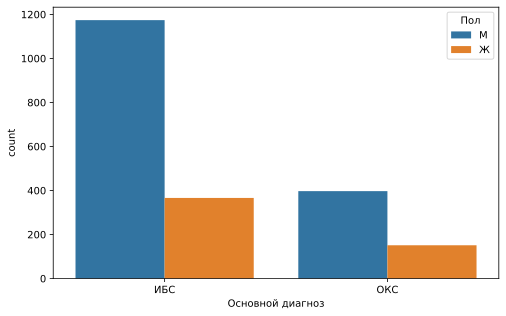

In [11]:
sns.countplot(x="Основной диагноз", hue="Пол", data=df[(df["Пол"] != "") & (df["Основной диагноз"] != "")])

2.2 Анализ возраста пациентов

<AxesSubplot:title={'center':'ИБС'}, xlabel='Полных лет', ylabel='Пол'>

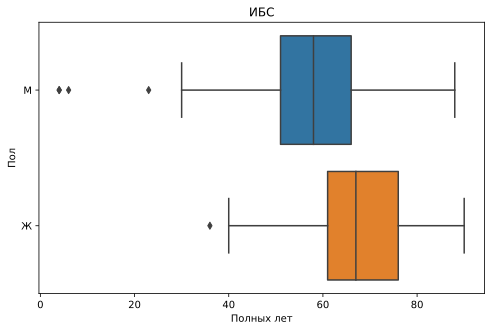

In [12]:
show_df = df[(df["Пол"] != "") & (df["Полных лет"] != "")]
show_df["Полных лет"] = show_df["Полных лет"].astype("int64")
IBS = sns.boxplot(y="Пол", x="Полных лет", data=show_df[show_df["Основной диагноз"] == "ИБС"], orient="h")
IBS.set_title("ИБС")
IBS

<AxesSubplot:title={'center':'ОКС'}, xlabel='Полных лет', ylabel='Пол'>

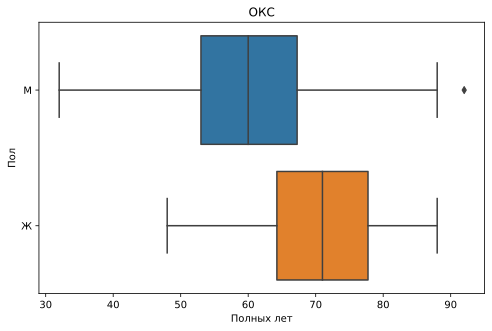

In [13]:
OCS = sns.boxplot(y="Пол", x="Полных лет", data=show_df[show_df["Основной диагноз"] == "ОКС"], orient="h")
OCS.set_title("ОКС")
OCS

2.3 Анализ цели поступления для каждого диагноза

<AxesSubplot:xlabel='Основной диагноз', ylabel='count'>

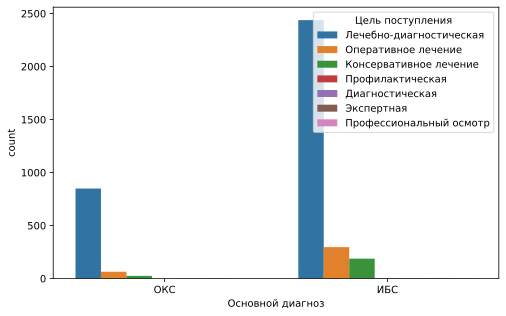

In [14]:
sns.countplot(x="Основной диагноз", hue="Цель поступления", data=df[(df["Цель поступления"] != "") & (df["Основной диагноз"] != "")])

2.4 Анализ повторных госпитализаций для каждого диагноза

<AxesSubplot:xlabel='Основной диагноз', ylabel='count'>

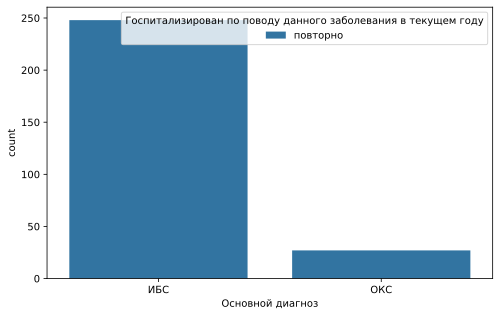

In [15]:
sns.countplot(x="Основной диагноз", hue="Госпитализирован по поводу данного заболевания в текущем году", 
              data=df[(df["Основной диагноз"] != "") & (df["Госпитализирован по поводу данного заболевания в текущем году"] != "первично")])

2.5 Анализ госпитализаций у мужчин и женщин

<AxesSubplot:xlabel='Пол', ylabel='count'>

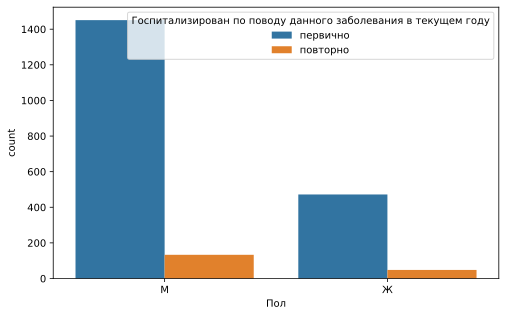

In [16]:
sns.countplot(x="Пол", hue="Госпитализирован по поводу данного заболевания в текущем году", 
              data=df[(df["Пол"] != "") & (df["Госпитализирован по поводу данного заболевания в текущем году"] != "")])

2.6 Анализ результата госпитализации для каждого диагноза 

<AxesSubplot:xlabel='Основной диагноз', ylabel='count'>

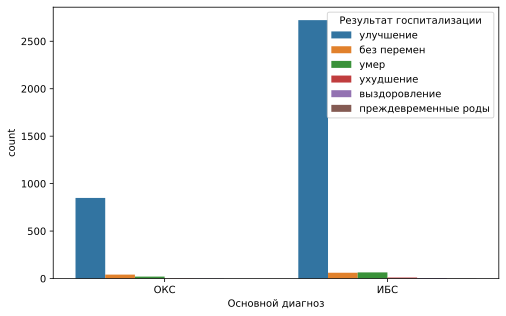

In [17]:
sns.countplot(x="Основной диагноз", hue="Результат госпитализации", data=df[(df["Основной диагноз"] != "") & (df["Результат госпитализации"] != "")])

2.7 Анализ результата госпитализации для мужчин и женщин

<AxesSubplot:xlabel='Пол', ylabel='count'>

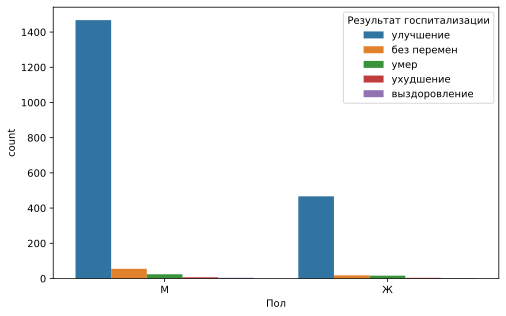

In [18]:
sns.countplot(x="Пол", hue="Результат госпитализации", data=df[(df["Пол"] != "") & (df["Результат госпитализации"] != "")])

2.8 Анализ места выписки для каждого диагноза

<AxesSubplot:xlabel='Основной диагноз', ylabel='count'>

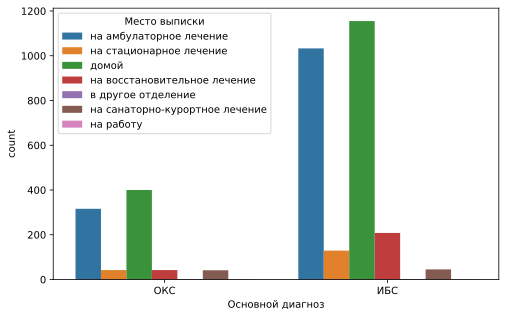

In [19]:
sns.countplot(x="Основной диагноз", hue="Место выписки", data=df[(df["Основной диагноз"] != "") & (df["Место выписки"] != "")])

2.9 Анализ количества проведённых дней в реанимационном отделении для каждого диагноза

<AxesSubplot:xlabel='Пребывание в отделении реанимации (койко-день)', ylabel='Основной диагноз'>

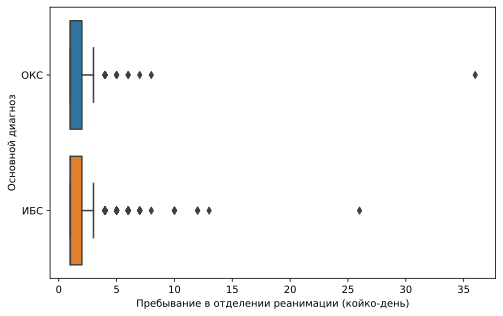

In [20]:
show_df = df[["Основной диагноз"] + ["Пребывание в отделении реанимации (койко-день)"]]
show_df = show_df[(show_df["Основной диагноз"]!= "") & (show_df["Пребывание в отделении реанимации (койко-день)"]!= "")]
show_df["Пребывание в отделении реанимации (койко-день)"] = show_df["Пребывание в отделении реанимации (койко-день)"].astype("int64")
sns.boxplot(y="Основной диагноз", x="Пребывание в отделении реанимации (койко-день)", data=show_df[show_df["Основной диагноз"] != ""], orient="h")

2.10 Анализ промежутка времени от поступления в приемное отделение до поступления в реанимационное отделение

In [21]:
def calculate_time(time):
    if time == "": return 0.0
    if "." in time:
        time = [int(x) for x in time.split(".")]
        return time[0]*60*24
    if ":" in time:
        time = [int(x) for x in time.split(":")]
        return time[0]*60 + time[1]
df["от поступления до поступления минут"] = df["Дата поступления в реанимационное отделение"].apply(calculate_time) + \
                                      df["Время поступления в реанимационное отделение"].apply(calculate_time) - \
                                      df["Дата поступления в приемное отделение"].apply(calculate_time) - \
                                      df["Время поступления в приемное отделение"].apply(calculate_time)
df[df["от поступления до поступления минут"] > 0]["от поступления до поступления минут"].describe()    

count     3263.000000
mean       526.047196
std       1864.813114
min          1.000000
25%         11.000000
50%         28.000000
75%         90.000000
max      24256.000000
Name: от поступления до поступления минут, dtype: float64

<AxesSubplot:xlabel='от поступления до поступления минут', ylabel='Density'>

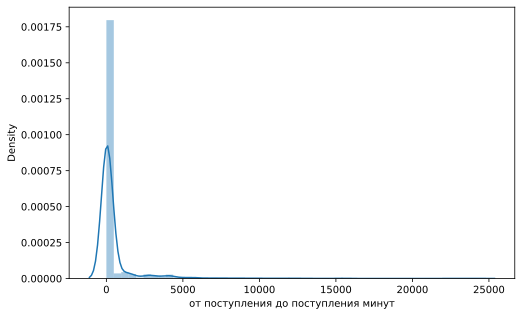

In [22]:
sns.distplot(df[df["от поступления до поступления минут"] > 0]["от поступления до поступления минут"]) 

2.11 Анализ промежутка времени от поступления в приемное отделение до поступления в реанимационное отделение

In [23]:
df["от поступления до выписки минут"] = df["Дата выписки"].apply(calculate_time) + \
                                      df["Время выписки"].apply(calculate_time) - \
                                      df["Дата поступления в приемное отделение"].apply(calculate_time) - \
                                      df["Время поступления в приемное отделение"].apply(calculate_time)
df[df["от поступления до выписки минут"] > 0]["от поступления до выписки минут"].describe()    

count     2019.000000
mean     16409.722140
std       8602.152631
min         27.000000
25%       9825.000000
50%      18087.000000
75%      22800.000000
max      42503.000000
Name: от поступления до выписки минут, dtype: float64

<AxesSubplot:xlabel='от поступления до выписки минут', ylabel='Density'>

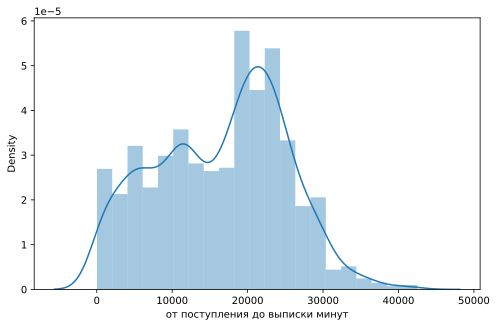

In [24]:
sns.distplot(df[df["от поступления до выписки минут"] > 0]["от поступления до выписки минут"]) 

2.12 Анализ взаимосвязи этих промежутков времени

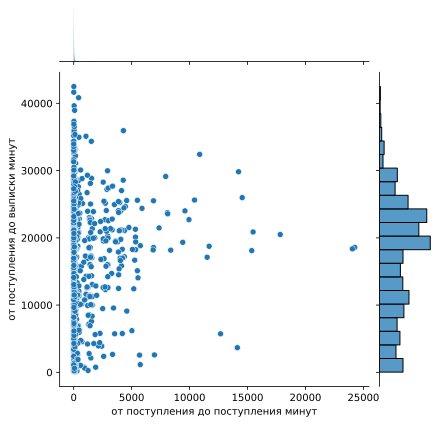

In [25]:
first_df = df[df["от поступления до поступления минут"] > 0]["от поступления до поступления минут"]
first_df = first_df[~first_df.index.duplicated()]
second_df = df[df["от поступления до выписки минут"] > 0]["от поступления до выписки минут"]
second_df = second_df[~second_df.index.duplicated()]
sns.jointplot(first_df,second_df)